In [1]:
%%capture

# This command installs several Python packages that are necessary for fine-tuning and optimizing language models:
!pip install accelerate       # A PyTorch extension for distributed training and performance optimization.
!pip install peft             # PEFT (Parameter-efficient Fine-tuning): Techniques for efficient fine-tuning of models.
!pip install bitsandbytes     # Library for efficient training of deep learning models, focusing on memory and speed optimization.
!pip install transformers     # Provides thousands of pre-trained models to perform tasks on texts such as classification, information extraction, and more.
!pip install trl              # Token-level Reinforcement Learning for training language models.


In [2]:
# Importing essential modules and functions from various libraries:
import os                        # os module: Provides a way of using operating system dependent functionality.
import torch                     # PyTorch: A deep learning framework for tensor computation and automatic differentiation.

# datasets: A library from Hugging Face for loading and processing datasets.
from datasets import load_dataset

# AutoModelForCausalLM: Loads a model for causal language modeling (like GPT) from a pre-trained model.
# AutoTokenizer: Loads the tokenizer that corresponds to a pre-trained model.
# BitsAndBytesConfig: Configuration for bitsandbytes to optimize model training.
# TrainingArguments: Defines training parameters.
# pipeline: Simplifies the process of making predictions with models.
# logging: Used for logging events in the transformers library.
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)

# LoraConfig: Configuration for LoRA (Low-Rank Adaptation), a technique for parameter-efficient training.
from peft import LoraConfig

# SFTTrainer: Trainer class from the trl (Token-level Reinforcement Learning) library for model training.
from trl import SFTTrainer


In [10]:
# Load the dataset
dataset = load_dataset("mlabonne/guanaco-llama2-1k", split="train") # "mlabonne/guanaco-llama2-1k" is a dataset tailored for LLaMA models

In [12]:
# Print the dataset structure
print("Dataset Structure:", dataset)

# Show the number of examples in the dataset
print("Number of examples in the dataset:", dataset.num_rows)

# List the columns in the dataset
print("Columns in the dataset:", dataset.column_names)

# Show the first few examples from the dataset
print("First few examples from the dataset:", dataset[:5])

Dataset Structure: Dataset({
    features: ['text'],
    num_rows: 1000
})
Number of examples in the dataset: 1000
Columns in the dataset: ['text']
First few examples from the dataset: {'text': ['<s>[INST] Me gradué hace poco de la carrera de medicina ¿Me podrías aconsejar para conseguir rápidamente un puesto de trabajo? [/INST] Esto vale tanto para médicos como para cualquier otra profesión tras finalizar los estudios aniversarios y mi consejo sería preguntar a cuántas personas haya conocido mejor. En este caso, mi primera opción sería hablar con otros profesionales médicos, echar currículos en hospitales y cualquier centro de salud. En paralelo, trabajaría por mejorar mi marca personal como médico mediante un blog o formas digitales de comunicación como los vídeos. Y, para mejorar las posibilidades de encontrar trabajo, también participaría en congresos y encuentros para conseguir más contactos. Y, además de todo lo anterior, seguiría estudiando para presentarme a las oposiciones y e

First few rows of the DataFrame:
                                                text
0  <s>[INST] Me gradué hace poco de la carrera de...
1  <s>[INST] Самый великий человек из всех живших...
2  <s>[INST] Compose a professional email with th...
3  <s>[INST] ¿Qué juegos me recomendarías si me h...
4  <s>[INST] Cual es el desarrollo motor de niño/...
Basic statistics of the DataFrame:
                                                     text
count                                                1000
unique                                               1000
top     <s>[INST] Me gradué hace poco de la carrera de...
freq                                                    1
Descriptive statistics of text lengths:
count     1000.000000
mean      1499.042000
std       1255.753823
min         58.000000
25%        660.000000
50%       1206.500000
75%       1943.250000
max      11443.000000
Name: text_length, dtype: float64


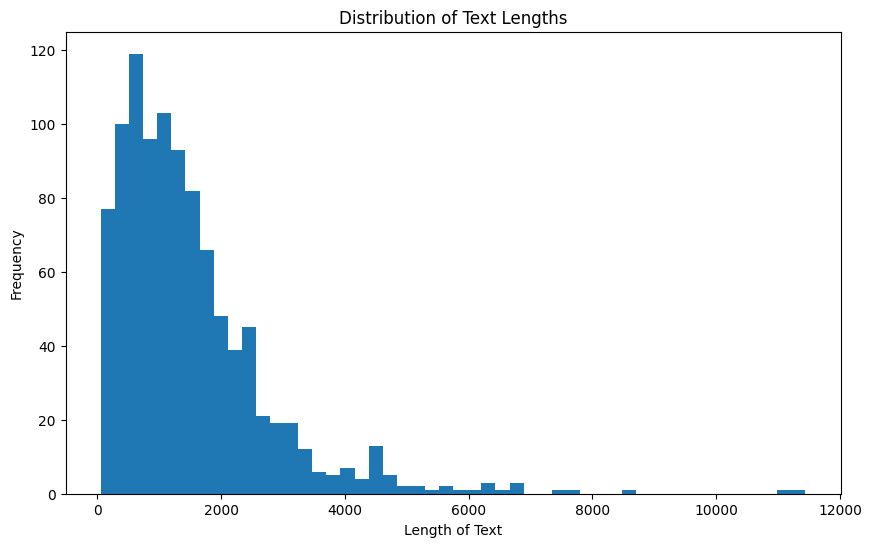

In [14]:
import pandas as pd

# Convert the dataset to a Pandas DataFrame
df = pd.DataFrame(dataset)

# Display the first few rows of the DataFrame to understand its structure
print("First few rows of the DataFrame:")
print(df.head())

# Basic statistics about the dataset
# This might include counts, means, and other descriptive stats depending on the data types
print("Basic statistics of the DataFrame:")
print(df.describe())

# If your dataset includes textual data, you can analyze the length of the text entries
# Assuming 'text' is a column in your dataset. If not, replace 'text' with the appropriate column name.
if 'text' in df.columns:
    df['text_length'] = df['text'].str.len()
    print("Descriptive statistics of text lengths:")
    print(df['text_length'].describe())

    # Visualizing the distribution of text lengths
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.hist(df['text_length'], bins=50)
    plt.title('Distribution of Text Lengths')
    plt.xlabel('Length of Text')
    plt.ylabel('Frequency')
    plt.show()


In [15]:
df.sample(2)

,text,text_length
639,<s>[INST] I have to choose which one to buy be...,1591
345,<s>[INST] ¿Puedes explicar la necesidad de apr...,1515


In [18]:
# Model from Hugging Face hub
base_model = "NousResearch/Llama-2-7b-chat-hf"

In [19]:
# Fine-tuned model name
new_model = "abhi/Llama-2-7b-chat-finetuned"

In [20]:
# Get the PyTorch data type for floating point 16-bit precision.
# This is typically used to reduce the memory and computation requirements
# without significantly impacting the model's performance accuracy.
compute_dtype = getattr(torch, "float16")

# Configure BitsAndBytes for quantization.
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Enable loading model weights in 4-bit precision. This reduces the model's memory footprint further.
    bnb_4bit_quant_type="nf4",  # Set the quantization type to "nf4", which stands for "near-float 4-bit". This is a quantization scheme designed to maintain high accuracy with lower bit rates.
    bnb_4bit_compute_dtype=compute_dtype,  # Specify the data type for computation. Here it uses 16-bit floating points as defined above.
    bnb_4bit_use_double_quant=False,  # Determines whether to use double quantization. Setting this to False uses single quantization, which is simpler and faster.
)

In [21]:
# Load the pre-trained model from the Hugging Face Model Hub.
# The model is specified by the 'base_model' variable, which should contain the model identifier.
# 'quantization_config' applies the quantization settings defined earlier to optimize the model.
# 'device_map' specifies the mapping of model parts to devices. Here, it assigns the model to GPU 0.
# Note: Adjust this according to your hardware setup, especially if you don't have a GPU or have a different configuration.
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
)

# Disable caching of past hidden states.
# This is useful for saving memory during training or inference, especially in generative tasks where caching is less beneficial.
model.config.use_cache = False

# Set 'pretraining_tp' to 1 in the model's configuration.
# This option might be specific to the model's architecture or training procedure.
# Since it's not a standard configuration option in Hugging Face's Transformers, it's likely specific to this model or a custom addition.
model.config.pretraining_tp = 1


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

In [22]:
# Load the tokenizer for the specified base model from Hugging Face's Model Hub.
# 'trust_remote_code=True' allows for the execution of custom tokenization logic from the remote model repository, if available.
# This can be important for models with custom tokenization processes.
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)

# Set the padding token to be the same as the end-of-sequence (eos) token.
# This is common in models designed for generative tasks, where the eos token can also serve to pad sequences to a uniform length.
tokenizer.pad_token = tokenizer.eos_token

# Specify that padding should be added to the right of the sequences.
# This means if a batch of sequences is shorter than the longest sequence, padding tokens will be added to the end until they match the longest sequence's length.
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [23]:
# Configure PEFT using LoRA for efficient fine-tuning of the model.
peft_params = LoraConfig(
    lora_alpha=16,    # The learning rate multiplier for LoRA parameters. This amplifies the updates applied to the adapted parameters.
    lora_dropout=0.1, # Dropout rate applied to the LoRA projections. Helps in preventing overfitting by randomly dropping units from the projections during training.
    r=64,              # Rank of the low-rank matrices in LoRA. A higher rank allows for more complex adaptations but increases the number of parameters to be trained.
    bias="none",       # Specifies how biases are handled in LoRA adaptations. "none" means that biases are not adapted as part of the LoRA process.
    task_type="CAUSAL_LM", # Indicates the type of task the model is being fine-tuned for. Here, it specifies a causal language modeling task.
)

In [24]:
training_params = TrainingArguments(
    output_dir="./results",  # Directory where the training results and model checkpoints will be saved.
    num_train_epochs=1,  # The total number of training epochs. One epoch means the model has seen the entire dataset once.
    per_device_train_batch_size=4,  # Batch size per device during training. Adjust based on your GPU memory.
    gradient_accumulation_steps=1,  # Number of steps to accumulate gradients before performing a backward/update pass.
    optim="paged_adamw_32bit",  # The optimizer to use. "paged_adamw_32bit" is an optimized version of AdamW for 32-bit precision.
    save_steps=25,  # Save a checkpoint of the model every 25 steps.
    logging_steps=25,  # Log training information every 25 steps.
    learning_rate=2e-4,  # The initial learning rate for AdamW.
    weight_decay=0.001,  # Weight decay rate to apply for regularization and prevent overfitting.
    fp16=False,  # Whether to use 16-bit (mixed) precision instead of 32-bit. False means 32-bit is used.
    bf16=False,  # Whether to use bfloat16 precision. False means it's not used, maintaining higher precision calculations.
    max_grad_norm=0.3,  # Maximum norm of the gradients for gradient clipping. Helps prevent the exploding gradient problem.
    max_steps=-1,  # If positive, set total number of training steps to perform. Overrides `num_train_epochs`. -1 means use `num_train_epochs`.
    warmup_ratio=0.03,  # Proportion of training to perform linear learning rate warmup. Helps stabilize the model's early training stages.
    group_by_length=True,  # Whether to group samples of similar lengths together. Improves training efficiency.
    lr_scheduler_type="constant",  # The learning rate scheduler type. "constant" means the learning rate does not change.
    report_to="tensorboard"  # Logging the results to TensorBoard. Helps in monitoring the training process visually.
)

In [25]:
trainer = SFTTrainer(
    model=model,  # The pre-trained model you've loaded and possibly modified with quantization settings.
    train_dataset=dataset,  # The training dataset you've loaded, which the model will learn from.
    peft_config=peft_params,  # The PEFT (Parameter-efficient Fine-tuning) configuration, specifically for LoRA in this context.
    dataset_text_field="text",  # The field in your dataset that contains the text data for training.
    max_seq_length=None,  # The maximum sequence length for model inputs. 'None' means the model's default or the dataset's max length is used.
    tokenizer=tokenizer,  # The tokenizer for processing text data to model-compatible inputs.
    args=training_params,  # The training arguments specifying how the model should be fine-tuned.
    packing=False,  # Whether to use data packing. Data packing can improve training efficiency but is set to 'False' here.
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:245: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
# Train model
trainer.train()

In [26]:
# Save the fine-tuned model to the specified directory. This will create the directory if it doesn't exist.
trainer.model.save_pretrained(new_model)

# Save the tokenizer to the same directory as the model. This ensures consistency between the model and tokenizer for future use.
trainer.tokenizer.save_pretrained(new_model)

('abhi/Llama-2-7b-chat-finetuned/tokenizer_config.json',
 'abhi/Llama-2-7b-chat-finetuned/special_tokens_map.json',
 'abhi/Llama-2-7b-chat-finetuned/tokenizer.model',
 'abhi/Llama-2-7b-chat-finetuned/added_tokens.json',
 'abhi/Llama-2-7b-chat-finetuned/tokenizer.json')

In [49]:
logging.set_verbosity(logging.CRITICAL)

prompt = "Who is Ronaldo?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


<s>[INST] Who is Ronaldo? [/INST]  Cristiano Ronaldo is a Portuguese professional footballer who plays as a forward for the Italian club Juventus and the Portugal national team. nobody. He is widely considered one of the greatest soccer players of all time, known for his exceptional skill, speed, and goalscoring ability.

Ronaldo was born on February 5, 1985, in Funchal, Madeira, Portugal. He began playing soccer at a young age and quickly emerged as a prodigious talent, joining the youth academy of Sporting CP at the age of 10. In 2001, he made his professional debut for Sporting CP, and in 2003, he moved to Manchester United in the English Premier League, where he spent six seasons and won numerous titles, including three Premier League titles and a Champions League title.

In
